# FIT5201 S1 2020 Assessment 1: Question 7 - Discriminative vs Generative Models


Student information
- Family Name:Muralitharan
- Given Name: Keerthana
- Student ID: 30159474
- Student email:kmur0015@student.monash.edu

Programming Language: R 3.3 in Jupyter Notebook

R Libraries used:
- reshape2
- ggplot
- mvtnorm

In [1]:
require(mvtnorm) # generates multivariate Gaussian sampels and calculate the densities
require(ggplot2)
require(reshape2)

Loading required package: mvtnorm

Loading required package: ggplot2

Loading required package: reshape2



## Question I. 
Load Task1E_train.csv and Task1E_test.csv as well as the Bayesian classifier (BC) and logistic regression (LR) codes.

#### reading the training and test dataset

reading the train and test dataset and assigning the classes

In [2]:
# Read the train and test data
task7train <- read.csv('Task1E_train.csv')
task7test <- read.csv('Task1E_test.csv')

# assigning the data and label.
train.data <- task7train[1:2]
test.data <- task7test[1:2]
train.label <- task7train[,3]
test.label <- task7test[,3]

#get the unique labels from the test label.
uni<-unique(test.label)

#assigning the unique classes to two variables
c0<-uni[1]
c1<-uni[2]

### Bayesian Classifier 

Build a bayesian classifier. ( calculate the probabilities,class means,covariance matrix,posterior)  using these calculate the prediction values and errors

In [3]:
Bayesian <- function(train.data, test.data,train.label,test.label ){

# Class probabilities:
p0.hat <- sum(train.label==c0)/nrow(train.data) # total number of samples in class 0 divided by the total nmber of training data
p1.hat <- sum(train.label==c1)/nrow(train.data) # or simply 1 - p1.hat

# Class means:
mu0.hat <- colMeans(train.data[train.label==c0,])
mu1.hat <- colMeans(train.data[train.label==c1,])

# class covariance matrices:
sigma0.hat <- var(train.data[train.label==c0,])
sigma1.hat <- var(train.data[train.label==c1,])

# shared covariance matrix:
sigma.hat <- p0.hat * sigma0.hat + p1.hat * sigma1.hat 

# calculate posteriors:
posterior0 <- p0.hat*dmvnorm(x=train.data, mean=mu0.hat, sigma=sigma.hat)
posterior1 <- p1.hat*dmvnorm(x=train.data, mean=mu1.hat, sigma=sigma.hat)
    
# calculate predictions:
train.predict <- ifelse(posterior0 > posterior1, c0, c1)
test.predict <- ifelse(p0.hat*dmvnorm(x=test.data, mean=mu0.hat, sigma=sigma.hat) > p1.hat*dmvnorm(x=test.data, mean=mu1.hat, sigma=sigma.hat), c0, c1)

#calculate the errors
train.error=(sum(train.label!=train.predict)/nrow(train.data)*100)
test.error=(sum(test.label!=test.predict)/nrow(test.data)*100)   
    
#store the errors in a dataframe
errors <-c(train.error,test.error)
#return the errors
return(errors)
}

## Question II

Using the first 5 data points from the training set, train a BC and a LR model, and compute their training and testing errors. In a “for loop”, increase the size of training set (5 data points at a time), retrain the models and calculate their training and testing errors until all training data points are used. In one figure, plot the training errors of the BC and LR models (with different colors) versus the size of the training set and in the other figure, plot the testing errors of the BC and LR models(with different colors) versus the size of the training set

#### error calculation for every batch size
For every batch size the training and test error is calculated.

In [4]:
#error for bayesian classifier
error_baye<-data.frame('Index'=1:(nrow(train.data)/5),'train'=0,'test'=0)

#Calculating the train and test errors for abyesian classifier
for (i in 1:(nrow(train.data/5))){
    iter=i*5
    if(iter>nrow(train.data)){break}
    #Calling the bayesian classifier function
    errors<-Bayesian(train.data[1:iter,],test.data,train.label[1:iter],test.label)
    error_baye[i,'train']<-errors[1]
    error_baye[i,'test']<-errors[2]

}

### Logistic Regression

Define the prediction,cost and sigmoid function

In [5]:
# auxiliary function that predicts class labels
predict <- function(w, X, c0, c1){
    sig <- sigmoid(w, X)
    return(ifelse(sig>0.5, c1,c0))
}
    
# auxiliary function that calculate a cost function

cost <- function (w, X, T, c0){
    sig <- sigmoid(w, X)
    return(sum(ifelse(T==c0, -log(1-sig), -log(sig)))/nrow(X))
}

# Sigmoid function (=p(C1|X))
sigmoid <- function(w, x){
    return(1.0/(1.0+exp(-w%*%t(cbind(1,x)))))    
}

#### Logistic regression function
- Initialize the parameters, terminating conditions,update the weights vectors and calculate the cost
- Predict the values and calculate the errors for training and test data

In [6]:
# Initializations
tau.max <- 1000 # maximum number of iterations
eta <- 0.01 # learning rate
epsilon <- 0.01 # a threshold on the cost (to terminate the process)
Logistic <- function(train.data,test.data,train.label,test.label){
    

train.len <- nrow(train.data)
tau <- 1 # iteration counter
terminate <- FALSE

#typecasting the data to a matrix
X <- as.matrix(train.data) 
T <- ifelse(train.label==c0,0,1) 

W <- matrix(,nrow=tau.max, ncol=(ncol(X)+1)) # to be used to store the estimated coefficients
W[1,] <- runif(ncol(W)) # initial weight 

# project data using the sigmoid function 
Y <- sigmoid(W[1,],X)

costs <- data.frame('tau'=1:tau.max)  # to be used to trace the cost in each iteration
costs[1, 'cost'] <- cost(W[1,],X,T, c0)

while(!terminate){
    # check termination criteria:
    terminate <- tau >= tau.max | cost(W[tau,],X,T, c0)<=epsilon
    
    # shuffle data:
    train.index <- sample(1:train.len, train.len, replace = FALSE)
    X <- X[train.index,]
    T <- T[train.index]
    
    # for each datapoint:
    for (i in 1:train.len){
        # check termination criteria:
        if (tau >= tau.max | cost(W[tau,],X,T, c0) <= epsilon) {terminate<-TRUE;break}
        
        Y <- sigmoid(W[tau,],X)
            
        # Update the weights
        W[(tau+1),] <- W[tau,] - eta * (Y[i]-T[i]) * cbind(1, t(X[i,]))
        
        # record the cost:
        costs[(tau+1), 'cost'] <- cost(W[tau,],X,T, c0)
        
        # update the counter:
        tau <- tau + 1
        
        # decrease learning rate:
        eta = eta * 0.999
    }
}

costs <- costs[1:tau, ] 

w <- W[tau,]

#predict the train and test values
pred_train<-predict(w,train.data,c0,c1)  
pred_test<-predict(w,test.data,c0,c1)

#record the train and test errors
train_error <- (sum(train.label!=pred_train)/nrow(test.data)*100) 
test_error <- (sum(test.label!=pred_test)/nrow(test.data)*100) 
pred<-c(train_error,test_error)

#return the train and test error dataframe
return(pred)

}

In [7]:
#create a empty dataframe for storing the train and test errors
error_logi<-data.frame('dataset_size'=1:(nrow(train.data)/5),'train'=0,'test'=0)

#for every data batches, calculate the train and test errors
for (i in 1:(nrow(train.data/5))){
    iter=i*5
    if(iter>nrow(train.data)){break}
    # call the logistic regression function to calculate the train and test errors
    errors<-Logistic(train.data[1:iter,],test.data,train.label[1:iter],test.label)
    error_logi[i,'train']<-errors[1]
    error_logi[i,'test']<-errors[2]
}

## Training error between logistic and bayesian classifier

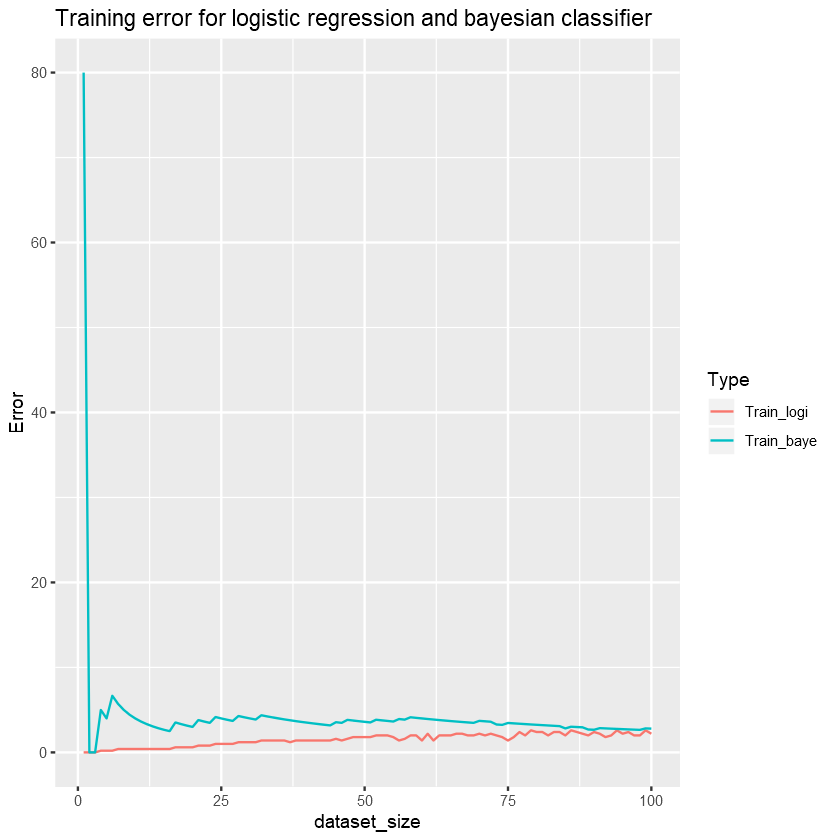

In [9]:
#create a dataframe with index and training errors of both logistic and bayesian classifier
train_error<-cbind(error_logi['dataset_size'],error_logi['train'],error_baye['train'])
names(train_error) <- c('dataset_size', 'Train_logi', 'Train_baye')

train_errors <- melt(train_error, id='dataset_size') # reshape for visualization

names(train_errors) <- c('dataset_size', 'Type', 'Error') # rename the columns

#plot the training error graph vs index
ggplot(data=train_errors, aes(x=dataset_size, y=Error, color=Type)) + geom_line() + ggtitle("Training error for logistic regression and bayesian classifier")

## Test error between logistic regression and bayesian classifier

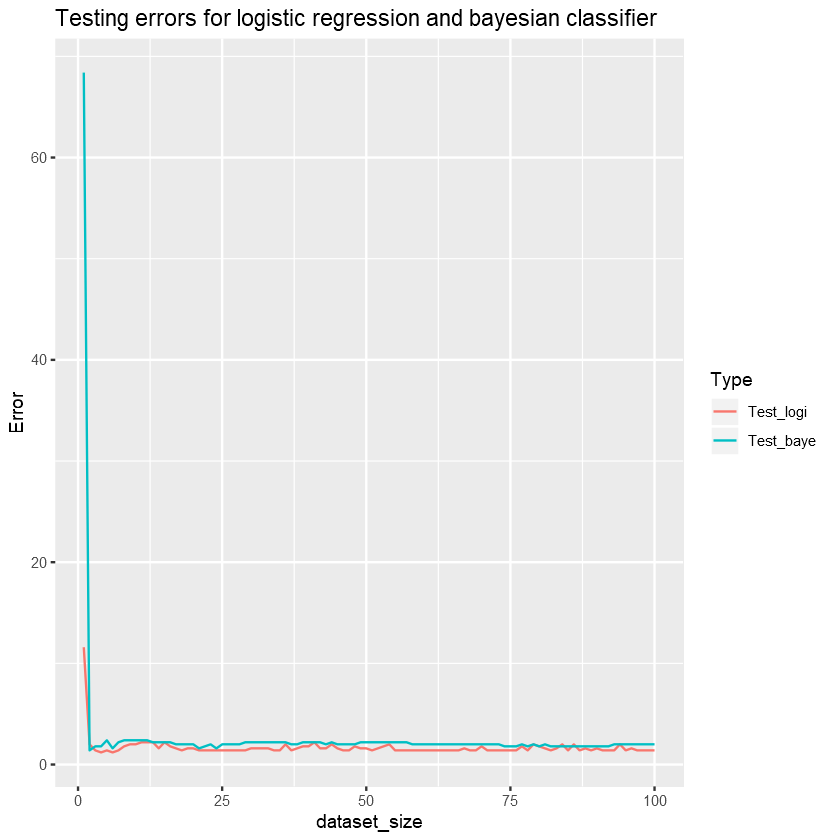

In [11]:
#create a dataframe to store the test errors of logistic regression and bayesian classifier
test_error<-cbind(error_logi['dataset_size'],error_logi['test'],error_baye['test'])
names(test_error) <- c('dataset_size', 'Test_logi', 'Test_baye')

test_errors <- melt(test_error, id='dataset_size') # reshape for visualization

names(test_errors) <- c('dataset_size', 'Type', 'Error') # rename the columns

#plot the testing errros graph
ggplot(data=test_errors, aes(x=dataset_size, y=Error, color=Type)) + geom_line() + ggtitle("Testing errors for logistic regression and bayesian classifier")

## Question III.

### Explain your observations in your Jupyter Notebook file.:
#### a. What does happen for each classifier when the number of training data points is increased?

**Solution** 
- the training error of logistic regression gradually increases as the dataset size increases to a very minimal errors whereas the training error in the bayesian classifier has a big drop with small data size and decreases as the datsize increases.
- the testing error of logistic regression decreases as the dataset size increases to a very minimal errors whereas the testing error in the bayesian classifier has a big drop with small data size and decreases as the datasize increases

#### b. Which classifier is best suited when the training set is small, and which is best suited when the training set is big?

**Solution** - **Logistic Regression** is the best for small dataset and as well as better for large dataset as we could see a increase in errors in logistic regression as the data size increases based on the training and testing errors.

#### c. Justify your observations in previous questions (III.a & III.b) by providing some speculations and possible reasons.

**Solution** - Bayesian trains the entire datapoint and build so there may be large errors
logistic regression considers datapoint by datapoint it will give more accurate values and less errors

-  As the dataset increases and the errors also decreases which implies that the model is complex. 
#### References:

- Tutorial materials

